**PROBLEM SET 3**

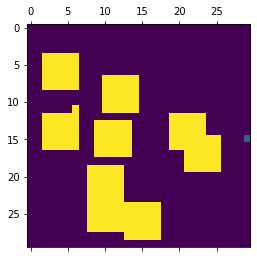

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_enviroment, action_space, transition_function,probabilistic_transition_function
from vi import vi, policy_vi
from mdp import mdp, policy_mdp
import vi
data = np.load('data_ps3.npz')
environment = data['environment']
x_ini = (11,6)
goal = (15,29)
im = plot_enviroment(environment,x_ini,goal)
plt.matshow(im)
plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
action_space = []
action_space.append((-1,0))
action_space.append((0,-1))
action_space.append((1,0))
action_space.append((0,1))
def plot_enviroment(env, x, goal):
    """
    env is the grid enviroment
    x is the state
    """
    dims = env.shape
    current_env = np.copy(env)
    current_env[x] = 1.0 
    current_env[goal] = 0.3
    return current_env

In [8]:
def state_consistency_check(env,x):
    """Checks wether or not the proposed state is a valid state, i.e. is in colision or our of bounds"""
    
    if x[0] < 0 or x[1] < 0 or x[0] >= env.shape[0] or x[1] >= env.shape[1] :
        return False
    if env[x] >= 1.0-1e-4:
        return False
    return True


In [9]:
def transition_function(env,x,u):
    """Transition function for states in this problem
    x: current state, this is a tuple (i,j)
    u: current action, this is a tuple (i,j)
    env: enviroment

    Output:
    new state
    True if correctly propagated
    False if this action can't be executed
    """
    xnew = np.array(x) + np.array(u)
    xnew = tuple(xnew)
    if state_consistency_check(env,xnew):
        return xnew, True
    return x, False

In [10]:
def probabilistic_transition_function(env,x,u, epsilon = 0.6):
    """Probabilistic Transition function requires:
    x: current state, this is a tuple (i,j)
    u: current action, this is a tuple (i,j)
    env: enviroment
    epsilon (in [0,1]): This is the probability of carrying out the desired action, in the extreme, 1 indicates a perfect action execution.

    Output:
    state_propagated_list: list of propagated states
    prob_list: list of the corresponding state's prob, in the same order
    """
    state_propagated_list = []
    prob_list = []
    for action in action_space:
        xnew = np.array(x) + np.array(action)
        xnew = tuple(xnew)
        prob = (1-epsilon)/3
        if action == u:
            prob = epsilon
        state_propagated_list.append(xnew)
        prob_list.append(prob)
    return state_propagated_list, prob_list

**TASK 1A** (2 pts) Enumerate the action space. The coordinates of actions are u = (row, column).

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import mdp
import vi

print("The list of actions are: ",action_space)

The list of actions are:  [(-1, 0), (0, -1), (1, 0), (0, 1)]


**TASK 1B**  (3 pts) Formulate mathematically the optimal cost-to-go G∗
(x) in recursive form.

To formulate the optimal cost-to-go function $G(x)$ in recursive form, we can use the Bellman equation. The Bellman equation expresses the optimal value of being in state x as the maximum value of the immediate cost plus the minimum value of the expected cost-to-go from the next states.

Mathematically, the optimal cost-to-go $G(x)$ is defined as:

$G(x) = min [c(x, u) + ∑ P_r ({x' | x, u}) G(x')]$

where:
- $G(x)$ is the optimal cost-to-go from state $x$.
- $c(x, u)$ is the immediate cost of taking action $u$ in state $x$.
- $P_r({x' | x, u})$ is the probability of transitioning to state $x'$ from state $x$ when taking action $u$.
- $G(x')$ is the optimal cost-to-go from state $x'$.

This recursive equation represents the optimal cost-to-go as the minimum cost of taking an action in the current state, plus the expected cost-to-go from all possible next states weighted by their transition probabilities.

To calculate the optimal cost-to-go for all states, we can iterate over all states $x$ and update $G(x)$ using the Bellman equation until it converges.

**TASK 1C**  (20 pts) Implement the VI algorithm for infinite length sequences. To show this, you are asked to include a
picture of the final G∗
(using imshow() for instance).
The cost of traversing each node l(x, u) = 1 only if propagation is possible (there is not obstacle or out of
bounds).
Hint: You can implement a convergence criterion or simply run for a large number of iteration, say 100.
Both options will be correct.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from utils import plot_enviroment, action_space, transition_function
from vi import vi, policy_vi
from mdp import mdp, policy_mdp

data = np.load('data_ps3.npz')
environment = data['environment']

x_ini = (11,6)
goal = (15,29)


In [13]:
def transition_function(environment,x,u):
    """Transition function for states in this problem
    x: current state, this is a tuple (i,j)
    u: current action, this is a tuple (i,j)
    env: enviroment

    Output:
    new state
    True if correctly propagated
    False if this action can't be executed
    """
    xnew = np.array(x) + np.array(u)
    xnew = tuple(xnew)
    if state_consistency_check(environment,xnew):
        return xnew, True
    return x, False

def vi(env, goal, gamma=1.0, epsilon=1e-6, max_iterations=100):
    """
    Value Iteration algorithm for infinite-length sequences.
    env: The grid environment.
    goal: The goal state as (x, y) coordinates.
    gamma: Discount factor.
    epsilon: Convergence threshold.
    max_iterations: Maximum number of iterations.

    Returns the optimal cost-to-go matrix G.
    """
    GRID_SIZE = env.shape
    action_space = [(0, 1), (0, -1), (1, 0), (-1, 0)]  
    G = np.zeros(GRID_SIZE) 
    for _ in range(max_iterations):
        old_G = np.copy(G)
        for i in range(GRID_SIZE[0]):
            for j in range(GRID_SIZE[1]):
                if (i, j) == goal:
                    continue  # Skip the goal state
                actions_cost = []
                for u in action_space:
                    xnew, success = transition_function(env, (i, j), u)
                    if success:
                        xnew_i, xnew_j = xnew
                        next_cost = 1.0  # Cost of traversal
                        next_cost += gamma * old_G[xnew_i, xnew_j]  # Future cost-to-go
                        actions_cost.append(next_cost)
                if actions_cost:
                    G[i, j] = np.min(actions_cost)
        if np.max(np.abs(G - old_G)) < epsilon:
            break
    return G

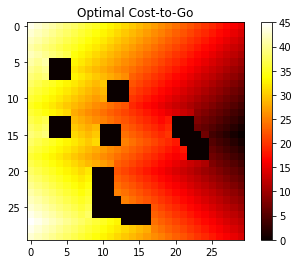

In [14]:
G = vi(environment, goal)
plt.imshow(G, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Optimal Cost-to-Go")
plt.show()

**Task 1D**  (5 pts) Experiment with different number of iterations. Start with a 1 iteration VI, describe the results
obtained and reason why.


**Comment**  If we run the Value Iteration algorithm with only 1 iteration, the result would not be optimal. Value Iteration is an iterative algorithm that updates the cost-to-go values based on the values of neighboring states. Each iteration refines the cost-to-go estimates until convergence is reached.

With only 1 iteration, the algorithm would only make one update to the cost-to-go values based on the neighboring states. This means that the algorithm would not have enough iterations to propagate the values effectively and accurately estimate the optimal cost-to-go for each state.

As a result, the obtained cost-to-go values would not accurately represent the true optimal cost-to-go values. The path planning or decision-making based on these values would likely be suboptimal.

In summary, running Value Iteration with only 1 iteration would not produce the optimal solution and would not effectively estimate the cost-to-go values. More iterations are needed to refine and converge the cost-to-go estimates towards the true optimal values.

**Task 2A**  (3 pts) Formulate how to obtain the optimal policy $u^
∗ = π_{V I} (x)$ from $G^∗$
.

To obtain the optimal policy from the optimal cost-to-go matrix $G^∗$, we can follow these steps:

1. Initialize an empty policy matrix $π$, with the same shape as $G^∗$.

2. For each state $(i, j)$ in the environment:
   - Initialize an empty list actions_cost.
   - For each possible action $u$ in the action_space:
     - Compute the new state xnew and the success flag by applying the transition_function with $(i, j)$ and u as inputs.
     - If success: Calculate the cost of traversal next_cost as $1.0$ plus the discounted cost-to-go value gamma $* G∗[x_{new}[0], x_{new}[1]]$.
     - Append the action-cost pair $(u, next_{cost})$ to the actions_cost list.

3. For each state $(i, j)$ in the environment:
   - If it is the goal state, set the policy $π[i, j]$ to None.
   - If it is not the goal state, set the policy $π[i, j]$ to the action $u$ that minimizes the cost next_cost in the actions_cost list.

4. Return the policy $π$, which represents the optimal action to take from each state in order to maximize the expected cumulative reward.

In summary, we iterate through each state, find the action that leads to the minimum cost of traversal plus the discounted cost-to-go value, and store it in the policy matrix. The resulting policy matrix provides the optimal action to take from each state to achieve the maximum expected cumulative reward.

**Task 2B**  . (17 pts) Implement an algorithm to obtain the optimal policy $u^
∗$
from $G^∗$
. This policy can be a table. To
test this, start at an initial position and execute the result of your policy and the transition function until
you reach the goal. You will upload the video, that should be automatically generated if using the code in
run.py.

In [15]:
def policy_vi(environment, G, action_space):
    """
    environment: grid environment
    G: optimal cost-to-go function
    action_space: list of possible actions
    output:
    policy: a map from each state x to the best action u to execute
    """
    rows, cols = environment.shape
    policy = np.empty(environment.shape, dtype=object)

    for i in range(rows):
        for j in range(cols):
            if environment[i, j] == 1:
                policy[i, j] = None
            else:
                actions_cost = []
                for u in action_space:
                    xnew, success = transition_function(environment, (i, j), u)
                    if success:
                        next_cost = 1.0 + G[xnew[0], xnew[1]]
                        actions_cost.append((u, next_cost))
                min_cost_action = min(actions_cost, key=lambda x: x[1])[0]
                policy[i, j] = min_cost_action

    return policy

In [16]:
def execute_policy(policy, x_ini , environment, transition_function):
    """
    policy: the optimal policy obtained
    initial_state: the starting state
    environment: grid environment
    transition_function: function to compute the next state given a state-action pair
    output:
    traj: a list of states, representing the trajectory taken using the policy
    """
    state = x_ini
    traj = [state]
    while policy[state[0], state[1]] is not None:
        action = policy[state[0], state[1]]
        state, success = transition_function(environment, state, action)
        if not success:
            print("Failed to execute action:", action)
            break
        traj.append(state)

    return traj


In [17]:
if 0:
    fig = plt.figure()
    imgs = []
    x = x_ini
    for plan_iters in range(100):
        im = plot_enviroment(environment,x,goal)
        plot = plt.imshow(im)
        imgs.append([plot])
        if x == goal:
            print('Goal achieved in iters =', plan_iters)
            break
    im = plot_enviroment(environment,x,goal)
    plot = plt.imshow(im)
    imgs.append([plot])
    ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True)
    ani.save('plan_vi.mp4')
    plt.show()

In [18]:
import cv2
import numpy as np

def draw_grid(environment, cell_size):
    """Draws the grid environment"""
    rows, cols = environment.shape
    grid = np.zeros((rows * cell_size, cols * cell_size, 3), dtype=np.uint8)

    for i in range(rows):
        for j in range(cols):
            if environment[i, j] == 1:
                color = (0, 255, 0)  # Green color for goal state
            elif environment[i, j] == 2:
                color = (0, 0, 255)  # Red color for obstacles
            else:
                color = (255, 255, 255)  # White color for empty cells

            grid[i*cell_size: (i+1)*cell_size, j*cell_size: (j+1)*cell_size] = color

    return grid

In [19]:
def visualize_policy(policy, initial_state, environment, transition_function, cell_size=20, delay=500,video_filename="output.mp4"):
    """
    policy: the optimal policy obtained
    initial_state: the starting state
    environment: grid environment
    transition_function: function to compute the next state given a state-action pair
    cell_size: size of each cell in pixels
    delay: delay between each frame in milliseconds
    output:
    frame_count: number of frames in the video
    """
    state = initial_state
    frames = []
    while policy[state[0], state[1]] is not None:
        grid = draw_grid(environment, cell_size)
        action = policy[state[0], state[1]]
        state, success = transition_function(environment, state, action)
        if not success:
            print("Failed to execute action:", action)
            break
        x, y = state
        cv2.rectangle(grid, (y*cell_size, x*cell_size), ((y+1)*cell_size, (x+1)*cell_size), (0, 0, 255), -1)
        frames.append(grid.copy())
        cv2.imshow("Policy Video",grid)
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.Video
    cv2.destroyAllWindows()
    return len(frames)

In [20]:
environment = data['environment']
policy = policy_vi(environment, G, action_space)
frame_count = visualize_policy(policy, x_ini, environment, transition_function, cell_size=50, delay=1000)
print("Total frames:", frame_count)


Total frames: 33


**Task 2C** (5 pts) Experiment with different parameters, such as starting points, the order of the states you use in VI (for loops) and the order of the actions. Explain your observations.

In [22]:
x_ini = (11,6)
action_space = [(0, 1), (0, -1), (-1, 0),(1, 0)] 
goal = (15,29)

In [23]:
def transition_function(environment,x,u):
    """Transition function for states in this problem
    x: current state, this is a tuple (i,j)
    u: current action, this is a tuple (i,j)
    env: enviroment

    Output:
    new state
    True if correctly propagated
    False if this action can't be executed
    """
    xnew = np.array(x) + np.array(u)
    xnew = tuple(xnew)
    if state_consistency_check(environment,xnew):
        return xnew, True
    return x, False

def vi(env, goal, gamma=1.0, epsilon=1e-6, max_iterations=100):
    """
    Value Iteration algorithm for infinite-length sequences.
    env: The grid environment.
    goal: The goal state as (x, y) coordinates.
    gamma: Discount factor.
    epsilon: Convergence threshold.
    max_iterations: Maximum number of iterations.

    Returns the optimal cost-to-go matrix G.
    """
    GRID_SIZE = env.shape
    action_space = [(0, 1), (0, -1), (-1, 0),(1, 0)]  
    G = np.zeros(GRID_SIZE) 
    for _ in range(max_iterations):
        old_G = np.copy(G)
        for i in range(GRID_SIZE[0]):
            for j in range(GRID_SIZE[1]):
                if (i, j) == goal:
                    continue  # Skip the goal state
                actions_cost = []
                for u in action_space:
                    xnew, success = transition_function(env, (i, j), u)
                    if success:
                        xnew_i, xnew_j = xnew
                        next_cost = 1.0  # Cost of traversal
                        next_cost += gamma * old_G[xnew_i, xnew_j]  # Future cost-to-go
                        actions_cost.append(next_cost)
                if actions_cost:
                    G[i, j] = np.min(actions_cost)
        if np.max(np.abs(G - old_G)) < epsilon:
            break
    return G

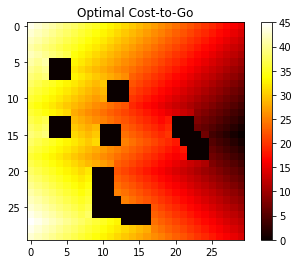

In [24]:
G = vi(environment, goal)
plt.imshow(G, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Optimal Cost-to-Go")
plt.show()

In [25]:
def policy_vi(environment, G, action_space):
    """
    environment: grid environment
    G: optimal cost-to-go function
    action_space: list of possible actions
    output:
    policy: a map from each state x to the best action u to execute
    """
    cols, rows = environment.shape
    policy = np.empty(environment.shape, dtype=object)

    for i in range(cols):
        for j in range(rows):
            if environment[i, j] == 1:
                policy[i, j] = None
            else:
                actions_cost = []
                for u in action_space:
                    xnew, success = transition_function(environment, (i, j), u)
                    if success:
                        next_cost = 1.0 + G[xnew[0], xnew[1]]
                        actions_cost.append((u, next_cost))
                min_cost_action = min(actions_cost, key=lambda x: x[1])[0]
                policy[i, j] = min_cost_action

    return policy

In [26]:
def execute_policy(policy, x_ini , environment, transition_function):
    """
    policy: the optimal policy obtained
    initial_state: the starting state
    environment: grid environment
    transition_function: function to compute the next state given a state-action pair
    output:
    traj: a list of states, representing the trajectory taken using the policy
    """
    state = x_ini
    traj = [state]
    while policy[state[0], state[1]] is not None:
        action = policy[state[0], state[1]]
        state, success = transition_function(environment, state, action)
        if not success:
            print("Failed to execute action:", action)
            break
        traj.append(state)

    return traj


In [27]:
if 0:
    fig = plt.figure()
    imgs = []
    x = x_ini
    for plan_iters in range(100):
        im = plot_enviroment(environment,x,goal)
        plot = plt.imshow(im)
        imgs.append([plot])
        if x == goal:
            print('Goal achieved in iters =', plan_iters)
            break
    im = plot_enviroment(environment,x,goal)
    plot = plt.imshow(im)
    imgs.append([plot])
    ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True)
    ani.save('plan_vi.mp4')
    plt.show()

In [28]:
import cv2
import numpy as np

def draw_grid(environment, cell_size):
    """Draws the grid environment"""
    cols, rows = environment.shape
    grid = np.zeros((cols * cell_size, rows * cell_size, 3), dtype=np.uint8)

    for i in range(cols):
        for j in range(rows):
            if environment[i, j] == 1:
                color = (0, 255, 0)  # Green color for goal state
            elif environment[i, j] == 2:
                color = (0, 0, 255)  # Red color for obstacles
            else:
                color = (255, 255, 255)  # White color for empty cells

            grid[i*cell_size: (i+1)*cell_size, j*cell_size: (j+1)*cell_size] = color

    return grid

In [29]:
def visualize_policy(policy, initial_state, environment, transition_function, cell_size=20, delay=500,video_filename="output.mp4"):
    """
    policy: the optimal policy obtained
    initial_state: the starting state
    environment: grid environment
    transition_function: function to compute the next state given a state-action pair
    cell_size: size of each cell in pixels
    delay: delay between each frame in milliseconds
    output:
    frame_count: number of frames in the video
    """
    state = initial_state
    frames = []
    while policy[state[0], state[1]] is not None:
        grid = draw_grid(environment, cell_size)
        action = policy[state[0], state[1]]
        state, success = transition_function(environment, state, action)
        if not success:
            print("Failed to execute action:", action)
            break
        y, x = state
        cv2.rectangle(grid, (x*cell_size, y*cell_size), ((x+1)*cell_size, (y+1)*cell_size), (0, 0, 255), -1)
        frames.append(grid.copy())
        cv2.imshow("Policy Video",grid)
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.Video
    cv2.destroyAllWindows()
    return len(frames)

In [30]:
environment = data['environment']
policy = policy_vi(environment, G, action_space)
frame_count = visualize_policy(policy, x_ini, environment, transition_function, cell_size=50, delay=1000)
print("Total frames:", frame_count)

AttributeError: module 'cv2' has no attribute 'Video'

**Observations:**

1. Starting Points: By changing the starting point, you can observe different trajectories being generated by executing the policy. The trajectory will follow the optimal path determined by the Value Iteration algorithm from the new starting point to the goal state.

2. Order of States: The order in which the states are visited during the Value Iteration algorithm does not affect the final optimal cost-to-go or policy since all states are iteratively updated based on their neighbors' values. The algorithm will converge to the same solution regardless of the order in which the states are processed.

3. Order of Actions: The order in which the actions are considered during the Value Iteration algorithm can have a slight impact on the convergence speed, but it should not affect the final solution significantly. Changing the order of actions in each state affects the exploration of the state-action space, potentially leading to different convergence rates or slightly different policies.

Overall, the provided code implements the Value Iteration algorithm, extracts the optimal policy, and allows for experiments with different starting points, state orders, and action orders. These experiments help understand how these parameters can impact the trajectories and convergence rates of the algorithm in different scenarios.

**Task 3A** (3 pts) Formulate the optimal value function $v_∗(x)$ in recursive form.

The optimal value function in recursive form can be formulated as follows:

$v_∗(x) = max(u(x, a) + βv_∗(f(x, a)))$

where:
- $v_∗(x)$ is the optimal value function for state $x$
- $u(x, a)$ is the immediate reward function for taking action $a$ in state $x$
- $f(x, a)$ is the transition function that returns the next state given current state $x$ and action $a$
- $β$ is the discount factor that represents the importance of future rewards

In this formulation, we take the maximum value of the immediate reward plus the discounted future value for each possible action $a$, and we recursively calculate the optimal value function for the next state $f(x, a)$ until we reach a terminal state. The optimal value function $v_∗(x)$ represents the maximum expected cumulative reward that can be obtained starting from state $x$.

**Task 3B**  (2 pts) Formulate how to obtain the greedy deterministic policy $u^∗$ = $π_{MDP}(x)$ from $v_∗(x)$

To obtain the greedy deterministic policy $u^∗$ = $π_{MDP} (x)$ from v_∗(x), we need to select the action $a$ in each state $x$ that maximizes the expression:

$u(x, a)$ + $βv_∗(f(x, a))$

In other words, the greedy policy chooses the action that yields the highest immediate reward plus the discounted future value. 

For each state $x$, we evaluate this expression for all possible actions $a$ and select the action that gives the maximum value. This action is then chosen as the policy for that state, resulting in a deterministic policy $u^∗$.

In mathematical notation, the greedy deterministic policy $u^∗$ = $π_{MDP} (x)$ can be formulated as:

$u^∗(x) = argmax(u(x, a) + βv∗(f(x, a)))$

where argmax is the function that returns the argument that maximizes the expression. This formulation ensures that the policy $u^∗$ selects the action that leads to the highest expected cumulative reward based on the optimal value function $v_∗$.